In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('dark_background')


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

# Eval Function

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def train_test_valid(data):
  train_size = int(0.7 * len(data))
  test_size = int(0.2 * len(data))
  val_size = len(data) - train_size - test_size

  train_data = data[:train_size]
  test_data = data[train_size:train_size+test_size]
  valid_data = data[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,10260.39,10443.02,10227.19,10227.19,10227.19,12637219.0
1,2019-01-03,10210.59,10260.39,9795.52,9795.52,9795.52,21178963.0
2,2019-01-04,9762.32,9961.55,9529.88,9861.93,9861.93,20085098.0
3,2019-01-07,10061.16,10077.77,9679.30,9745.71,9745.71,7495579.0
4,2019-01-08,9762.32,9795.52,9529.88,9579.69,9579.69,12767952.0
...,...,...,...,...,...,...,...
1537,2025-03-06,27600.00,27950.00,27600.00,27950.00,27950.00,37159600.0
1538,2025-03-07,28000.00,28100.00,27750.00,28050.00,28050.00,33131210.0
1539,2025-03-10,28100.00,28200.00,27950.00,27950.00,27950.00,23863520.0
1540,2025-03-11,27600.00,28150.00,27600.00,28150.00,28150.00,26088500.0


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format & reset index

In [ ]:
df_amz = df_amz.set_index(pd.DatetimeIndex(df_amz['Date'].values))

df_amz.index = pd.to_datetime(df_amz.index,format='%Y-%m-%d')

close_amz = pd.DataFrame(df_amz, columns=['Date', 'Close'])
close_amz.drop('Date', axis = 1, inplace = True)

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])

Starting date:  2019-01-02
Ending date:  2025-03-12


<ipython-input-11-f85b7d6a4d52>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-11-f85b7d6a4d52>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])


### Visualize the per day closing price of the stock

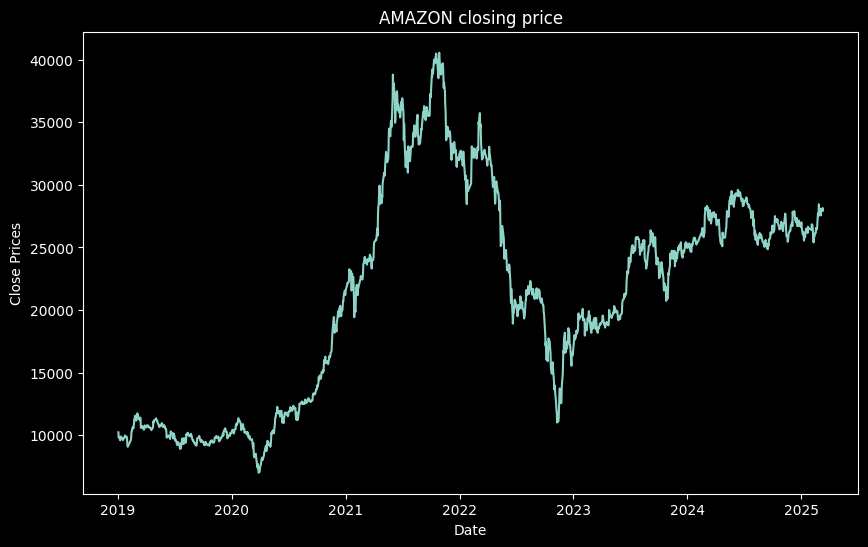

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
data_amz = close_amz.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_amz)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build & train model

In [ ]:
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.13536, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras
20/20 - 12s - 585ms/step - loss: 0.1354
Epoch 2/80

Epoch 2: loss improved from 0.13536 to 0.04494, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras
20/20 - 6s - 307ms/step - loss: 0.0449
Epoch 3/80

Epoch 3: loss improved from 0.04494 to 0.03533, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras
20/20 - 3s - 144ms/step - loss: 0.0353
Epoch 4/80

Epoch 4: loss improved from 0.03533 to 0.03149, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras
20/20 - 5s - 239ms/step - loss: 0.0315
Epoch 5/80

Epoch 5: loss improved from 0.03149 to 0.02899, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras
20/

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_HoaPhat_HPG_721.keras')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


In [ ]:
test = close_amz[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_amz[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
val = close_amz[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_amz[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
train_data = close_amz[:train_size]
test_data = close_amz[train_size:train_size+test_size]
val_data = close_amz[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  381.62453784496756
MAPE:  1.5275873593520168
RMSE:  489.20460007602634

** Validate **
MAE:  354.2435357862903
MAPE:  1.3309450628770405
RMSE:  451.3480024853652


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.5975312239043593, 0.6005103908875624, 0.5990208073959609, 0.6034895578707655, 0.594552056921156, 0.5885937229547498, 0.5856145559715467, 0.5796562220051402, 0.5796562220051402, 0.5796562220051402, 0.5885937229547498, 0.5975312239043593, 0.5930624734295544, 0.5826353889883433, 0.5751874715303356, 0.594552056921156, 0.594552056921156, 0.5960416404127575, 0.6168958092951797, 0.6109374753287735, 0.5975312239043593, 0.5751874715303356, 0.5632708035975229, 0.5602916366143198, 0.5498645521731087, 0.5543333026479134, 0.5617812201059214, 0.5692291375639291, 0.5751874715303356, 0.5766770550219371, 0.5751874715303356, 0.5781666385135387, 0.5885937229547498, 0.5930624734295544, 0.5960416404127575, 0.5871041394631482, 0.6213645597699844, 0.6139166423119766, 0.6154062258035782, 0.622854143261586, 0.6183853927867813, 0.6109374753287735, 0.601999974379164, 0.5960416404127575, 0.5960416404127575, 0.6064687248539686, 0.5915728899379529, 0.5871041394631482, 0.5960416404127575, 0.5871041394631

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.6255993843078613], [0.6266132593154907], [0.6279473304748535], [0.6288348436355591], [0.6295327544212341], [0.6301227807998657], [0.630616307258606], [0.6310259699821472], [0.6313636302947998], [0.631637454032898], [0.6318521499633789], [0.6320096850395203], [0.6321117877960205], [0.6321593523025513], [0.632153332233429], [0.6320956349372864], [0.6319884061813354], [0.6318333148956299], [0.6316334009170532], [0.6313914656639099], [0.6311097145080566], [0.6307910084724426], [0.630437970161438], [0.6300524473190308], [0.6296367049217224], [0.6291928887367249], [0.6287224292755127], [0.6282272338867188], [0.6277090311050415], [0.6271690130233765]]


In [ ]:
datelist_train = df_amz['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[27992.14794141]
 [28026.18010589]
 [28070.96011207]
 [28100.75076045]
 [28124.17713399]
 [28143.98221312]
 [28160.54813445]
 [28174.29904959]
 [28185.63310084]
 [28194.82438617]
 [28202.0309621 ]
 [28207.3188522 ]
 [28210.74607723]
 [28212.34264791]
 [28212.14057568]
 [28210.20388343]
 [28206.6045969 ]
 [28201.39873611]
 [28194.68833754]
 [28186.56743481]
 [28177.11005435]
 [28166.41223052]
 [28154.56199477]
 [28141.62136926]
 [28127.66638119]
 [28112.76905628]
 [28096.97741171]
 [28080.35547035]
 [28062.96125296]
 [28044.83477382]]


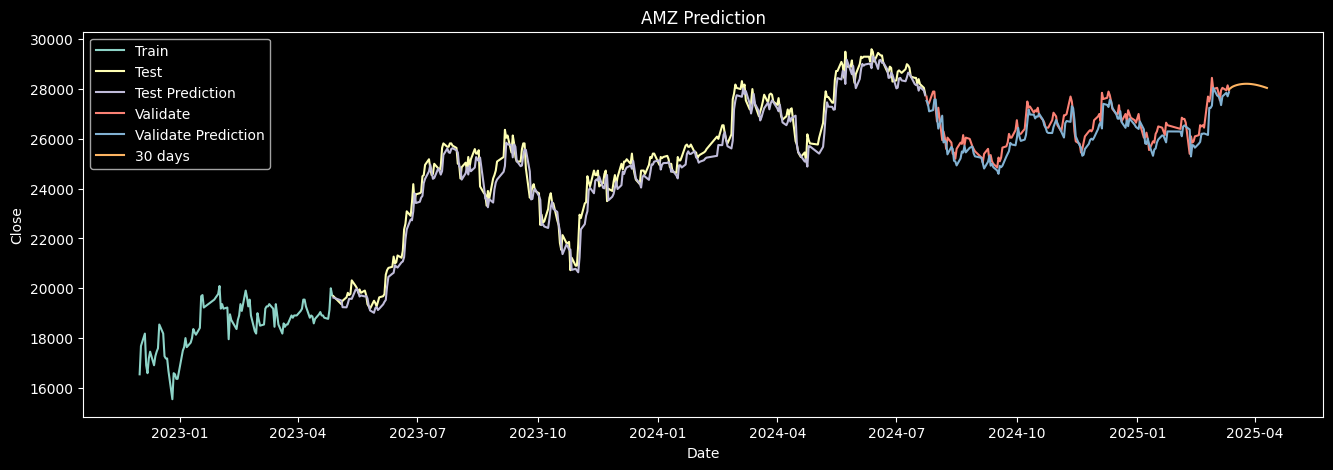

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('AMZ Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()

# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])

Starting date:  2019-01-02
Ending date:  2025-03-12


<ipython-input-32-1625b6c5d97d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-32-1625b6c5d97d>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])


### Visualize the per day closing price of the stock

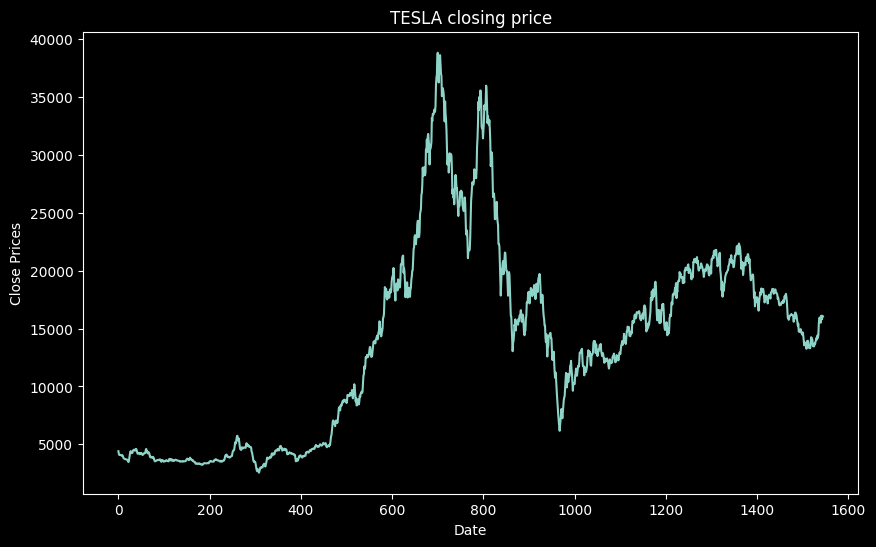

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

### Convert date from string to date format & reset index

In [ ]:
df_tsla = df_tsla.set_index(pd.DatetimeIndex(df_tsla['Date'].values))

df_tsla.index = pd.to_datetime(df_tsla.index,format='%Y-%m-%d')

close_tsla = pd.DataFrame(df_tsla, columns=['Date', 'Close'])
close_tsla.drop('Date', axis = 1, inplace = True)

### Split

In [ ]:
data_tsla = close_tsla.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_tsla)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build model

In [ ]:
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.10610, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras
20/20 - 8s - 410ms/step - loss: 0.1061
Epoch 2/80

Epoch 2: loss improved from 0.10610 to 0.04686, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras
20/20 - 3s - 148ms/step - loss: 0.0469
Epoch 3/80

Epoch 3: loss improved from 0.04686 to 0.03422, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras
20/20 - 3s - 126ms/step - loss: 0.0342
Epoch 4/80

Epoch 4: loss improved from 0.03422 to 0.02889, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras
20/20 - 3s - 168ms/step - loss: 0.0289
Epoch 5/80

Epoch 5: loss improved from 0.02889 to 0.02636, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras
20/20 - 3

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/LSTM_NamKim_NKG_721.keras')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


In [ ]:
test = close_tsla[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_tsla[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
val = close_tsla[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_tsla[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
train_data = close_tsla[:train_size]
test_data = close_tsla[train_size:train_size+test_size]
val_data = close_tsla[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  384.248687929814
MAPE:  2.1507993667198235
RMSE:  501.3070426911187

** Validate **
MAE:  317.35736139112925
MAPE:  1.9589894067710527
RMSE:  405.8858151520525


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.4134013726406447, 0.4168474477678393, 0.40995529751345006, 0.40076558005025764, 0.3984682885274646, 0.39961707213186615, 0.39961707213186615, 0.39961707213186615, 0.40536043878185385, 0.4065092223862554, 0.4042116551774523, 0.4042116551774523, 0.41110380543184155, 0.40536043878185385, 0.40995529751345006, 0.4202935228950339, 0.4168474477678393, 0.42259081441782703, 0.42603688954502167, 0.4179959556862308, 0.4065092223862554, 0.3858327716230876, 0.3686023959871145, 0.3697509039055059, 0.36400753725551827, 0.3686023959871145, 0.37319697903270055, 0.3743457626371021, 0.3743457626371021, 0.3766430541598952, 0.37779183776429676, 0.37549454624150375, 0.37549454624150375, 0.37549454624150375, 0.37089968750990754, 0.359412678523922, 0.37319697903270055, 0.3663048287783113, 0.3812379128914914, 0.3812379128914914, 0.37779183776429676, 0.37549454624150375, 0.3663048287783113, 0.359412678523922, 0.3502232367467397, 0.3548180954783359, 0.3364389362379612, 0.3364389362379612, 0.335060506

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.36563539505004883], [0.35937780141830444], [0.352107971906662], [0.3448810279369354], [0.33775317668914795], [0.33075225353240967], [0.32394376397132874], [0.31738123297691345], [0.31108757853507996], [0.305058091878891], [0.2992696166038513], [0.29368868470191956], [0.2882782518863678], [0.28300175070762634], [0.27782610058784485], [0.27272388339042664], [0.2676736116409302], [0.262660413980484], [0.2576752305030823], [0.2527143955230713], [0.2477785050868988], [0.24287162721157074], [0.23800013959407806], [0.23317186534404755], [0.22839535772800446], [0.22367914021015167], [0.219031423330307], [0.21445932984352112], [0.2099691927433014], [0.20556603372097015]]


In [ ]:
datelist_train = df_tsla['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[15809.04752996]
 [15582.06489752]
 [15318.36528117]
 [15056.22125851]
 [14797.67164102]
 [14543.72610522]
 [14296.7607421 ]
 [14058.71707096]
 [13830.42639934]
 [13611.71792544]
 [13401.75169351]
 [13199.3137135 ]
 [13003.06027241]
 [12811.66495368]
 [12623.92782054]
 [12438.8543308 ]
 [12255.66506609]
 [12073.82059538]
 [11892.99228732]
 [11713.04717597]
 [11534.00688179]
 [11356.01896459]
 [11179.31476352]
 [11004.1780474 ]
 [10830.91907017]
 [10659.84700471]
 [10491.25967317]
 [10325.41544031]
 [10162.54402376]
 [10002.82757607]]


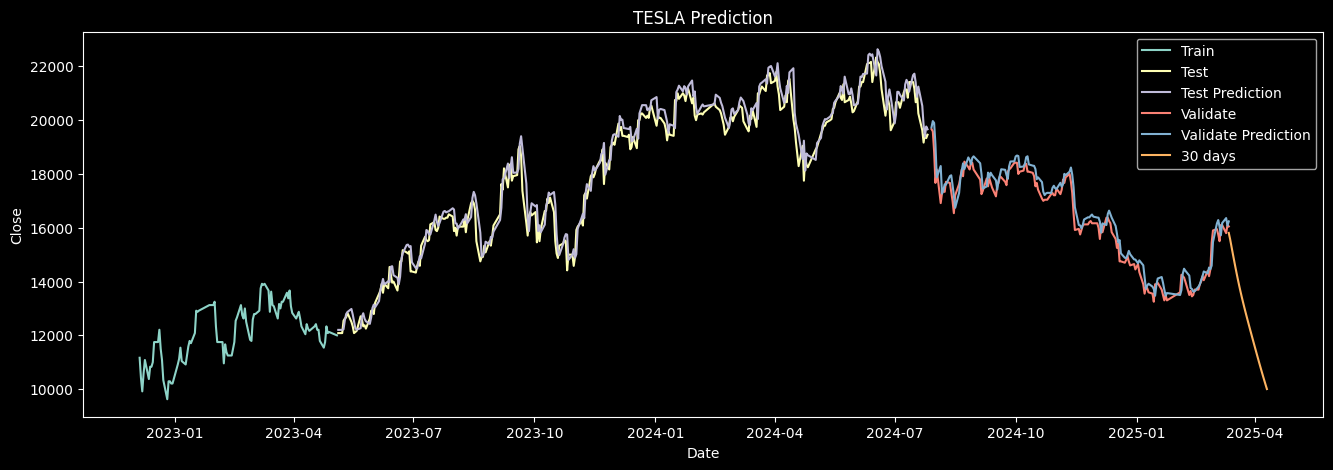

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))

plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('TESLA Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()